## Thermo-kinematic subduction


This code was written by Dan Sandiford, Louis Moresi and the Underworld Team. It is licensed under the Creative Commons Attribution 4.0 International License . We offer this licence to encourage you to modify and share the examples and use them to help you in your research.

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />

In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
import os
import sys
from easydict import EasyDict as edict
import operator
import pickle


In [2]:
#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
    sys.path.append('./unsupported')
except:
    pass

In [3]:
#
from unsupported_dan.utilities.interpolation import nn_evaluation
from unsupported_dan.interfaces.globalMarker2D import globalLine2D
from unsupported_dan.faults.faults2D import fault2D, fault_collection
from unsupported_dan.utilities.misc import cosine_taper
from unsupported_dan.utilities.subduction import slab_top



../unsupported/unsupported_dan/utilities/__init__.py:9: UserWarning: 

The utilities module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """
../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """
../unsupported/unsupported_dan/faults/__init__.py:9: UserWarning: 

The fault module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


## Setup out Dirs

In [4]:
############
#Model letter and number
############


#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 1

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg

In [5]:
###########
#Standard output directory setup
###########

outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
#checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
xdmfPath = outputPath + 'xdmf/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
    if not os.path.isdir(xdmfPath):
        os.makedirs(xdmfPath)
        
uw.barrier() #Barrier here so no procs run the check in the next cell too early

## Params

In [51]:
dp = edict({})
#Main physical paramters
dp.depth=300e3                         #Depth
dp.refDensity=3300.                        #reference density
dp.refGravity=9.8                          #surface gravity
dp.viscosityScale=1e20                       #reference upper mantle visc., 
dp.refDiffusivity=1e-6                     #thermal diffusivity
dp.refExpansivity=3e-5                     #surface thermal expansivity
dp.gasConstant=8.314                    #gas constant
dp.specificHeat=1250.                   #Specific heat (Jkg-1K-1)
dp.potentialTemp=1573.                  #mantle potential temp (K)
dp.surfaceTemp=273.                     #surface temp (K)
#Rheology - flow law paramters
dp.cohesionMantle=20e6                   #mantle cohesion in Byerlee law
dp.cohesionInterface=2e6                    #crust cohesion in Byerlee law
dp.frictionMantle=0.2                   #mantle friction coefficient in Byerlee law (tan(phi))
dp.frictionInterface=0.02                   #crust friction coefficient 
dp.diffusionPreExp=5.34e-10             #1./1.87e9, pre-exp factor for diffusion creep
dp.diffusionEnergy=3e5 
dp.diffusionVolume=5e-6

#Fk approach to interface
dp.delViscInterface = 1e4
dp.refViscInterface = 1e20
dp.refDepthInterface = 80e3

#
#dp.interfacePreExp=2e2*5.34e-10            
#dp.interfaceEnergy=0.4*3e5
#dp.interfaceVolume=5.*5e-6

#power law creep params
dp.powerLawStrain = 1e-15
dp.powerLawExp = 3.5


#Rheology - cutoff values
dp.viscosityMin=1e18
dp.viscosityMax=1e25                #viscosity max in the mantle material
dp.viscosityMinInterface=1e18               #viscosity min in the weak-crust material
dp.viscosityMaxInterface=1e25               #viscosity min in the weak-crust material
dp.crustViscCutoffDepth = 100e3
dp.crustViscEndWidth = 50e3
dp.ysMaxInterface = 50e6

#Intrinsic Lengths
dp.faultThickness = 8*1e3              #interface material (crust) an top of slabs
dp.leftSide=0.e3               #
dp.rightSide=1.5*dp.depth
dp.theta=45.                             #Angle of slab
dp.radiusOfCurv = 250e3                          #radius of curvature
dp.crossOverDepth = 125e3
dp.slabAge=70e6                     #age of subduction plate at trench
dp.opAge=35e6                       #age of op
dp.subZoneLoc=dp.leftSide                    #X position of subduction zone...km
dp.subVelocity = 4*(1/100.)*(1./(3600*24*365)) #m/s



#derived params
dp.deltaTemp = dp.potentialTemp-dp.surfaceTemp
dp.tempGradMantle = (dp.refExpansivity*dp.refGravity*(dp.potentialTemp))/dp.specificHeat
dp.tempGradSlab = (dp.refExpansivity*dp.refGravity*(dp.surfaceTemp + 400.))/dp.specificHeat



#Modelling and Physics switches

md = edict({})
md.refineMeshStatic=True
md.stickyAir=False
md.aspectRatio=1.5
md.res=72
md.ppc=40                                #particles per cell
md.elementType="Q1/dQ0"
#md.elementType="Q2/DPC1"
md.courantFac=0.5                         #extra limitation on timestepping
md.nltol = 0.001
md.maxSteps = 2000
md.druckerAlpha = 0.
md.druckerAlphaFault = 0.
md.penaltyMethod = False
md.spuniform = False
md.dissipativeHeating = True
md.powerLaw = False
md.interfaceDiffusivityFac = 1.
md.materialAdvection=False
md.wedgeType = 1  #1 is a triangular wedge, 2 is a curved / linear slab defined by params in dp.
md.plasticInterface = False
md.runTimeMa = 10.



In [7]:
##Parse any command-line args

from unsupported_dan.easymodels import easy_args
sysArgs = sys.argv

#We want to run this on both the paramter dict, and the model dict
easy_args(sysArgs, dp)
easy_args(sysArgs, md)

../unsupported/unsupported_dan/easymodels/__init__.py:9: UserWarning: 

The easymodels module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """


In [8]:
sf = edict({})

sf.lengthScale=300e3
sf.viscosityScale = dp.viscosityScale
sf.stress = (dp.refDiffusivity*sf.viscosityScale)/sf.lengthScale**2
sf.lithGrad = dp.refDensity*dp.refGravity*(sf.lengthScale)**3/(sf.viscosityScale*dp.refDiffusivity) 
sf.lithGrad = (sf.viscosityScale*dp.refDiffusivity) /(dp.refDensity*dp.refGravity*(sf.lengthScale)**3)
sf.velocity = dp.refDiffusivity/sf.lengthScale
sf.strainRate = dp.refDiffusivity/(sf.lengthScale**2)
sf.time = 1./sf.strainRate
sf.actVolume = (dp.gasConstant*dp.deltaTemp)/(dp.refDensity*dp.refGravity*sf.lengthScale)
sf.actEnergy = (dp.gasConstant*dp.deltaTemp)
sf.diffusionPreExp = 1./sf.viscosityScale
sf.deltaTemp  = dp.deltaTemp
sf.pressureDepthGrad = (dp.refDensity*dp.refGravity*sf.lengthScale**3)/(dp.viscosityScale*dp.refDiffusivity)


In [9]:
#dimesionless params
ndp  = edict({})

ndp.rayleigh = (dp.refExpansivity*dp.refDensity*dp.refGravity*dp.deltaTemp*sf.lengthScale**3)/(dp.viscosityScale*dp.refDiffusivity)
ndp.dissipation = (dp.refExpansivity*sf.lengthScale*dp.refGravity)/dp.specificHeat


#Take care with these definitions, 
ndp.surfaceTemp = dp.surfaceTemp/sf.deltaTemp  #Ts
ndp.potentialTemp = dp.potentialTemp/sf.deltaTemp - ndp.surfaceTemp #Tp' = Tp - TS

ndp.tempGradMantle = dp.tempGradMantle/(sf.deltaTemp/sf.lengthScale)
ndp.tempGradSlab = dp.tempGradSlab/(sf.deltaTemp/sf.lengthScale)

#lengths / distances
ndp.depth = dp.depth/sf.lengthScale
ndp.leftSide = dp.leftSide/sf.lengthScale             #
ndp.rightSide = dp.rightSide/sf.lengthScale
ndp.faultThickness = dp.faultThickness/sf.lengthScale



#times - for convenience the dimensional values are in years, conversion to seconds happens here
ndp.slabAge =  dp.slabAge*(3600*24*365)/sf.time
ndp.opAge = dp.opAge*(3600*24*365)/sf.time


#Rheology - flow law paramters
ndp.cohesionMantle=dp.cohesionMantle/sf.stress                  #mantle cohesion in Byerlee law
ndp.cohesionInterface=dp.cohesionInterface/sf.stress                  #crust cohesion in Byerlee law
ndp.frictionMantle=dp.frictionMantle/sf.lithGrad                  #mantle friction coefficient in Byerlee law (tan(phi))
ndp.frictionInterface=dp.frictionInterface/sf.lithGrad                  #crust friction coefficient 
ndp.diffusionPreExp=dp.diffusionPreExp/sf.diffusionPreExp                #pre-exp factor for diffusion creep
ndp.diffusionEnergy=dp.diffusionEnergy/sf.actEnergy
ndp.diffusionVolume=dp.diffusionVolume/sf.actVolume
#


#
ndp.powerLawStrain = dp.powerLawStrain/sf.strainRate
ndp.powerLawExp = dp.powerLawExp

#Fk approach to interface
ndp.logDelVisc = np.log(dp.delViscInterface)
ndp.refViscInterface = dp.refViscInterface/sf.viscosityScale
ndp.refDepthInterface = dp.refDepthInterface/sf.lengthScale


#Rheology - cutoff values
ndp.viscosityMin= dp.viscosityMin /sf.viscosityScale
ndp.viscosityMax=dp.viscosityMax/sf.viscosityScale
ndp.viscosityMinInterface= dp.viscosityMinInterface /sf.viscosityScale
ndp.viscosityMaxInterface= dp.viscosityMaxInterface /sf.viscosityScale
ndp.crustViscCutoffDepth = dp.crustViscCutoffDepth/sf.lengthScale
ndp.crustViscEndWidth = dp.crustViscEndWidth/sf.lengthScale
ndp.ysMaxInterface  = dp.ysMaxInterface/sf.stress

#Slab and plate init. parameters
ndp.subZoneLoc = dp.subZoneLoc/sf.lengthScale
ndp.radiusOfCurv = dp.radiusOfCurv/sf.lengthScale
ndp.crossOverDepth = dp.crossOverDepth/sf.lengthScale
ndp.theta=dp.theta #Angle of slab
ndp.subVelocity = dp.subVelocity/sf.velocity


## Build the slab top function, 

This creates a function that follows a circular arc until the crossOverDepth, after which a consant slope.

In [10]:
if ndp.crossOverDepth > ndp.radiusOfCurv:
    ndp.crossOverDepth = ndp.radiusOfCurv - 1e-3

yCircCoords = (ndp.radiusOfCurv - ndp.crossOverDepth)
xCrossOver = ndp.subZoneLoc + np.sqrt(ndp.radiusOfCurv**2 - yCircCoords**2)
slopeCrossOver = max(-1*(xCrossOver)/yCircCoords, -99.) #-99 is basically the verical slab limit

maxX = xCrossOver + (ndp.depth - ndp.crossOverDepth)*(-1./slopeCrossOver)

def slabFn(x): 
    if x < xCrossOver:
        dy = ndp.radiusOfCurv - np.sqrt(ndp.radiusOfCurv**2 - x**2)
        y = 1. - dy
    else:
        y = 1. - ndp.crossOverDepth + (x - xCrossOver)*slopeCrossOver
        
    return y

#vectorize the slab function
vslabFn= np.vectorize(slabFn)


## Make mesh / FeVariables

In [11]:
#Domain and Mesh paramters
yres = int(md.res)
xres = int(md.res*md.aspectRatio) 



mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (ndp.leftSide, 1. - ndp.depth), 
                                 maxCoord    = (ndp.rightSide, 1.)) 

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
initialtemperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

stressField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3 )


temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 ) #create this only if Adv-diff
diffusivityFn = fn.misc.constant(1.)
    


In [12]:
velocityField.data[:] = 0.
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
initialtemperatureField.data[:] = 0.

In [13]:
#Uw geometry shortcuts

coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1] #a function providing the depth


xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]


## Swarm

In [14]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
materialVariable      = swarm.add_variable( dataType="int", count=1 )

layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(md.ppc))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.


In [15]:
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )
directorVector   = swarm.add_variable( dataType="double", count=2)

#To be general we'll have swarm variables  for friction coefficient and cohesion
fcVariable = swarm.add_variable( dataType="double", count=1 )
fMuVariable= swarm.add_variable( dataType="double", count=1 )


directorVector.data[:,:] = 0.0
proximityVariable.data[:] = 0
signedDistanceVariable.data[:] = 0.0

In [16]:
#swarm.particleGlobalCount

## Fault / interface

We build a markerLine object to help set up the temperature stencil and the subduction interface

In [17]:
#Create some slab gradient functions to use with slab_top()


def linearGradientFn(S):
    return np.tan(np.deg2rad(-1.*ndp.theta))


def circGradientFn(S):
    if S == 0.:
        return 0.
    elif S < ndp.radiusOfCurv:
        return -S/np.sqrt((ndp.radiusOfCurv**2 - S**2))
    else:
        return -1e5
    
    
def polyGradientFn(S):
    if S == 0.:
        return 0.
    else:
        return -1*(S/ndp.radiusOfCurv)**2
    
    
sCrossOver = xCrossOver - ndp.subZoneLoc
def mixedGradientFn(S):
    if S == 0.:
        return 0.
    elif S < sCrossOver:
        return -S/np.sqrt((ndp.radiusOfCurv**2 - S**2))
    else:
        return slopeCrossOver

In [18]:
#choose the type of slab shape to use

if md.wedgeType == 1:
    gradFn = linearGradientFn
    
elif md.wedgeType == 2:
    gradFn = mixedGradientFn

In [19]:
#create the fault

ds = 1e3/sf.lengthScale
normal = [1.,0.]

faultData = slab_top([ndp.subZoneLoc, 1.0], normal, gradFn, ds, ndp.depth, mesh)
fault = globalLine2D(mesh, velocityField, faultData[:,0] , faultData[:,1] , ndp.faultThickness, 1.)




In [20]:
#also create another marker line to help to refine the mesh
#this one sits at the bottom of the weak zone

markerData = faultData + fault.director[:]*ndp.faultThickness
    

marker = globalLine2D(mesh, velocityField, markerData[:,0] , markerData[:,1] , ndp.faultThickness, 1.)


In [21]:
#This block sets a number of variables that we'll used to define / control the fault geom

# set the proximity

sd, dnz = fault.compute_signed_distance(swarm.particleCoordinates.data)
f, nz = fault.compute_marker_proximity(swarm.particleCoordinates.data)    
proximityVariable.data[nz] = f[nz]

dv, nzv = fault.compute_normals(swarm.particleCoordinates.data)
directorVector.data[nzv] = dv[nzv]


##Now use the signed distance var to set everything above the fault to zero

sd, dnz = fault.compute_signed_distance(swarm.particleCoordinates.data, distance=3*ndp.depth)
proximityVariable.data[dnz[(sd < 0)[:,0]]] = 0.
directorVector.data[dnz[(sd < 0)[:,0]]] = 0.

signedDistanceVariable.data[dnz] = sd[dnz]

#Create a binary function to distinguish above and below the slab

upperLowerVar = uw.swarm.SwarmVariable(swarm, 'double', 1)
upperLowerVar.data[...] = 1.
upperLowerVar.data[dnz[(sd > 0)[:,0]]  ] = 0.  

upperLowerMeshVar = uw.mesh.MeshVariable(mesh, 1, dataType='double')
projectorMisc = uw.utils.MeshVariable_Projection( upperLowerMeshVar, upperLowerVar, type=0 )
projectorMisc.solve()

## Set up some distance variables

The temperature stencil is set using a depth / distance field (and a cooling model), which follows the curve of the slab into the mantle.

In [22]:
#this  is a correction for wedge-like slabs, or any slabs that do not intersect the surface at 0 degree dip
angleCorrect = 1./(np.sin(np.deg2rad(90. - np.abs(np.rad2deg(np.arctan(gradFn(0.)))))))

conditions = [ (upperLowerVar > 0, depthFn),
                   (                      True , angleCorrect*signedDistanceVariable   ) ]

distFn = fn.branching.conditional( conditions )
    

## Temp. Field

In [23]:
proxyTempVariable = uw.swarm.SwarmVariable(swarm, 'double', 1)

conditions = [ (upperLowerVar > 0, fn.math.erf((distFn)/(2.*np.sqrt(1.*ndp.opAge)))),
                   (                      True , fn.math.erf((distFn)/(2.*np.sqrt(1.*ndp.slabAge)))   ) ]

tempFn = fn.branching.conditional( conditions )

proxyTempVariable.data[:] = tempFn.evaluate(swarm)

In [24]:
ix0, weights0, d0 = nn_evaluation(swarm.particleCoordinates.data, 
                                  mesh.data , n=200, weighted=False)


temperatureField.data[:,0] =  np.average(tempFn.evaluate(swarm)[:,0][ix0], weights=weights0, axis=len((weights0.shape)) - 1)

initialtemperatureField.data[:,0] =  np.average(tempFn.evaluate(swarm)[:,0][ix0], weights=weights0, axis=len((weights0.shape)) - 1)

## Mesh deformation

Here I use proximity to a marker line to define nodes to adjust. The nodes effectivey sit right on yhe marker line and become the nodes we impose velocity on.


In [25]:
#This value seems to provide good results for a square mesh.
#We end up with at least one node in every element lying on the interface

ds = 0.35*(mesh.maxCoord[1] - mesh.minCoord[1])/mesh.elementRes[1]


#We do this in two parts as signed Distance and kdtree work a bit differenlty
dN, pIgnore  = marker.compute_signed_distance(mesh.data, distance=ds)
nearbyNodesMask = np.where(np.abs(dN) < ds)[0]
signedDists = dN[nearbyNodesMask]

#This call is to get pN, the nodes in the marker Line that are closes to the mesh nodes
dIgnore, pN = marker.kdtree.query(mesh.data, distance_upper_bound=ds)
nearbyNodesMask2 = np.where(dIgnore != np.inf)
markerIndexes = pN[nearbyNodesMask2]


#now we can use the director to define the mesh adjustment
nodeDs = marker.director[markerIndexes]*signedDists
nodeAdjust = mesh.data[nearbyNodesMask] - nodeDs


#Hacky test for making sure no node displacements are greater than ds.
np.allclose(np.floor(np.linalg.norm(nodeDs/ds, axis=1)), 0.)


uw.barrier()
    
with mesh.deform_mesh():
    mesh.data[nearbyNodesMask] = nodeAdjust

In [91]:
fig= glucifer.Figure()
#fig= glucifer.Figure(quality=3)
fig.append( glucifer.objects.Points(swarm, proximityVariable, pointSize=1.5))
#fig.append( glucifer.objects.Points(fault.swarm, pointSize=3, colourBar=False))
#fig.append( glucifer.objects.Points(marker.swarm, pointSize=3, colourBar=False))

#fig.append( glucifer.objects.Points(markerEvalMantle, pointSize=3, colourBar=False))
#fig.append( glucifer.objects.Points(markerEvalFault, pointSize=3, colourBar=False))


fig.append( glucifer.objects.Mesh(mesh, opacity=0.4))
#fig.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)))
#fig.append( glucifer.objects.Surface(mesh, bcMeshVar))


#fig.show()

#fig.save_image('proximity.png')

#fig.save_database('test0.gldb')

## Boundary Conditions

In [27]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]
rWalls = mesh.specialSets["MaxI_VertexSet"]
      
    

### Temp BCs

In [28]:
#make sure tempBcs are set exactly on mesh BCs

fTleft = fn.math.erf((depthFn)/(2.*np.sqrt(1.*ndp.slabAge)))
temperatureField.data[lWalls.data] = fTleft.evaluate(lWalls)

fTright = fn.math.erf((depthFn)/(2.*np.sqrt(1.*ndp.opAge)))
temperatureField.data[rWalls.data] = fTright.evaluate(rWalls)

temperatureField.data[tWalls.data] = 0.


del fTleft 
del fTright

### Velocity BCs

In [29]:
nodes = nearbyNodesMask 

#some matplolib plotting for the node config.


try:
    %pylab inline
    fig, ax = plt.subplots(figsize=(8,8))
    #ax.scatter(mesh.data[:,0], mesh.data[:,1],s = 10, c = 'r')
    ax.scatter(mesh.data[:,0], mesh.data[:,1],s = 1., c ='b')


    #neumannNodes0 = rWalls - tWalls - bWalls 
    #neumannNodes1 = lWalls + bWalls - drivenVelNodes
    #neumannNodes = neumannNodes0 + neumannNodes1

    #dirichNodes = drivenVelNodes + tWalls

    #ax.scatter(mesh.data[neumannNodes.data][:,0], mesh.data[neumannNodes.data][:,1],s = 10)
    ax.scatter(mesh.data[nodes][:,0], mesh.data[nodes][:,1],s = 3, c = 'r')

    ax.scatter(fault.particleCoordinates[:,0], fault.particleCoordinates[:,1],s = 1)


    ax.set_aspect('equal')
    ax.set_ylim(0.4, 1.)
    ax.set_xlim(0., 0.8)
except:
    pass

In [30]:
#Now we actually set the velocity. 
#this simply involves grabbbing the normal to the director, and mapping to mesh nodes

tangentVel = marker.director[:].copy()[:,-1::-1]

tangentVel[:,0]*=-1.  #these should be unit vectors, but a normalisation here would be good


velocityField.data[nearbyNodesMask] = tangentVel[markerIndexes]*ndp.subVelocity


velocityField.data[tWalls.data]  = (0.,0.)

In [31]:
drivenVel = mesh.specialSets["Empty"]
drivenVel.add(nodes)
drivenVel = drivenVel - lWalls - bWalls - rWalls - tWalls

In [32]:
#All the bCs

stressField.data[...] = (0.0,0.0,0.0)


#Velocity
#velNbc = uw.conditions.NeumannCondition( flux=stressField, 
#                                      variable=velocityField,
#                                      nodeIndexSet=(rWalls - tWalls - bWalls ) )

velDbc = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( tWalls + drivenVel,  tWalls + drivenVel) )



#Temp

dT_dy = [0.,0.]
tempNbc = uw.conditions.NeumannCondition( flux=dT_dy, variable=temperatureField,
                                              nodeIndexSet = (bWalls) )
    
    
tempDbc = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof =  tWalls + iWalls )

## Rheology

In [33]:
symStrainrate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )

#Set up any functions required by the rheology
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))



def safe_visc(func, viscmin=ndp.viscosityMin, viscmax=ndp.viscosityMax):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))



#Add some portion of dynamic pressure to the depth-dependent Yield function
dynamicPressureProxyDepthFn = pressureField/sf.pressureDepthGrad

druckerDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlpha*(dynamicPressureProxyDepthFn))
druckerFaultDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlphaFault*(dynamicPressureProxyDepthFn))

In [34]:
##Mantle rheology
diffusion = (1./ndp.diffusionPreExp)*\
            fn.math.exp( ((ndp.diffusionEnergy + (depthFn*ndp.diffusionVolume))/((temperatureField+  ndp.surfaceTemp))))
    

    
    
viscosity0 = safe_visc(diffusion, viscmax=1e5)

if md.powerLaw:
    powerLawSRFn= ((strainRate_2ndInvariant+ 1e-15)/ndp.powerLawStrain)**((1.-ndp.powerLawExp)/ndp.powerLawExp)
    viscPower = viscosity0*powerLawSRFn
    effviscosity = viscPower*viscosity0/(viscPower + viscosity0)
    viscosity = safe_visc(effviscosity, viscmax=1e5)

else:
    viscosity = viscosity0

mantleViscosityFn = safe_visc(viscosity,  viscmax=ndp.viscosityMax)


In [35]:
normDepths = depthFn/ndp.refDepthInterface
interfaceCreep = ndp.refViscInterface*fn.math.exp(ndp.logDelVisc*(1. - normDepths) )
#interfaceCreep = safe_visc(interfaceCreep0, viscmin=ndp.viscosityMinInterface, viscmax= ndp.viscosityMaxInterface)

if md.plasticInterface:
    interfaceys =  ndp.cohesionInterface + (druckerFaultDepthFn*ndp.frictionInterface)
    interfaceysf = fn.misc.min(interfaceys, ndp.ysMaxInterface)
    interfaceYielding = interfaceysf/(2.*(strainRate_2ndInvariant) + 1e-15)


else: # an equivalent visc implementation
    ndp.effStrainRate = ndp.subVelocity/ndp.faultThickness
    effStressUpper =  ndp.cohesionInterface + (depthFn*ndp.frictionInterface)
    interfaceYielding = effStressUpper/(2.*ndp.effStrainRate)   
    
#combine
interfaceViscosityFn = safe_visc(fn.misc.min(interfaceCreep , interfaceYielding), viscmin=ndp.viscosityMinInterface, viscmax=ndp.viscosityMaxInterface)


depthTaperFn = cosine_taper(depthFn, ndp.crustViscCutoffDepth, ndp.crustViscEndWidth)
interfaceViscosityFn =  interfaceViscosityFn*(1. - depthTaperFn) + depthTaperFn*mantleViscosityFn


In [36]:
viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                         mapping = {0:mantleViscosityFn,
                                    1:interfaceViscosityFn} )

viscosityTI2_fn = viscosityMapFn - 10.

# This one maps to my fault-proximity variable (which also picks only materialV)
viscosity2Map    = { 0: 0.0, 
                     1: viscosityTI2_fn                  
                   }

secondViscosityFn  = fn.branching.map( fn_key = proximityVariable, 
                                       mapping = viscosity2Map )

In [37]:
div = (velocityField.fn_gradient[0] + velocityField.fn_gradient[3])

In [90]:
fig= glucifer.Figure(quality=3)

fig.append( glucifer.objects.Points(swarm,viscosityMapFn, logScale=True, pointSize=2))
#fig.append( glucifer.objects.Points(swarm, temperatureField, pointSize=1.8))
fig.append( glucifer.objects.Contours(mesh,temperatureField, colours='black', interval=0.26,))
#fig.append( glucifer.objects.Contours(mesh,initialtemperatureField, colours='blue', interval=0.26))
#fig.append( glucifer.objects.Points(swarm, strainRate_2ndInvariant, logScale=True))
#fig.append( glucifer.objects.Points(swarm, fn.math.dot(velocityField, velocityField)))

fig.append( glucifer.objects.VectorArrows(mesh, upperLowerMeshVar*velocityField*0.0006, arrowHead=0.2, glyphs=3  ))
fig.append( glucifer.objects.Mesh(mesh, opacity = 0.3  ))
#fig.show()
#fig.save_image('test.png')


In [39]:
#plt.plot(mesh.data[lWalls.data][:,1]*sf.lengthScale, depthTaperFn.evaluate(lWalls))
#plt.plot(mesh.data[bWalls.data][:,0]*sf.lengthScale, velocityField[1].evaluate(bWalls))
#plt.plot(mesh.data[tWalls.data][:,0]*sf.lengthScale, velocityField[0].evaluate(tWalls))

In [40]:
uw.barrier()

## Stokes

In [41]:
stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velDbc,],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = (0., 0.) )

stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velDbc,velNbc],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = (0., 0.) ,
                                    _fn_viscosity2  = secondViscosityFn,
                                    _fn_director    = directorVector)

In [42]:
solver = uw.systems.Solver(stokesPIC)


In [43]:

if md.penaltyMethod:
    solver.set_inner_method("mumps")
    solver.options.scr.ksp_type="cg"
    solver.set_penalty(1.0e7)
    solver.options.scr.ksp_rtol = 1.0e-4

else:
    #solver.options.main.Q22_pc_type='gkgdiag'
    solver.options.scr.ksp_rtol=5e-5
    solver.set_inner_method('mumps')
    #solver.options.mg.levels = 5

In [44]:
#solver.options.mg.levels

In [45]:
print("First solve")

First solve


In [46]:
solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol)


In [47]:
uw.barrier()

In [48]:
print("solve done")

solve done


In [49]:
fig.save_database('test.gldb')

'test.gldb'

## Dissipative heatingFn

In [70]:
#dissipative heating in terms of the sqrt. strain rate second invariant is:

if md.dissipativeHeating:
    dissHeatfn = (ndp.dissipation/ndp.rayleigh)*8.*viscosityMapFn*fn.math.sqrt(strainRate_2ndInvariant)
else:
    dissHeatfn = fn.misc.constant(0.)
    
#also a swarmVar for the total change in temp in the Eulerian (we don't advect the swarm in this model) reference    
accumulatedTemp = uw.swarm.SwarmVariable(swarm, 'double', 1)
accumulatedTemp.data[:] = 0.

## fault diffusivity

In [71]:
diffusivityFn = fn.branching.map( fn_key = proximityVariable,
                         mapping = {0:1.,
                                    1:md.interfaceDiffusivityFac} )

## Advection - Diffusion

In [72]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = dissHeatfn,
                                         fn_diffusivity = diffusivityFn , 
                                         conditions     = [tempNbc, tempDbc] )


In [73]:
if md.materialAdvection:
    advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
    population_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.006, splitThreshold=0.25, maxDeletions=1, maxSplits=3, aggressive=True,aggressiveThreshold=0.9, particlesPerCell=int(md.ppc))



In [74]:
dt = advDiff.get_max_dt()*md.courantFac #additional md.courantFac helps stabilise advDiff
advDiff.integrate(dt)
print(dt)

1.05879567649e-05


## Save some Xdmfs

In [75]:
# Any extra mesh vars. we want to define (mostly to facilite saving as xdmf)
strainRateField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
viscosityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [76]:
def save_xdmfs(step, time):
    
    #define any NN interps we'll need
    ix1, weights1, d1 = nn_evaluation(swarm.particleCoordinates.data, mesh.data, n=5, weighted=True)
    
    
    #rebuild any mesh vars that are not self-updating
    viscosityField.data[:,0] =  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix1], weights=weights1, axis=len((weights1.shape)) - 1)
    strainRateField.data[:] = strainRate_2ndInvariant.evaluate(mesh)
     
    
    fullpath = os.path.join(outputPath + "xdmf/")
    #if not os.path.exists(fullpath+"mesh.h5"):
    #    _mH = mesh.save(fullpath+"mesh.h5")
    
    try:
        _mH
    except:
        _mH = mesh.save(fullpath+"mesh.h5")
    
    
    #Part 1
    mh = _mH
    vH = velocityField.save(fullpath + "velocity_" + str(step) +".h5")
    tH = temperatureField.save(fullpath + "temp_" + str(step) + ".h5")
    srH = strainRateField.save(fullpath + "strainrate_" + str(step) +".h5")
    viscH = viscosityField.save(fullpath + "visc_" + str(step) + ".h5")
    
    #part2
    
    velocityField.xdmf(fullpath + "velocity_" + str(step), vH, 'velocity', mh, 'mesh', modeltime=time)
    temperatureField.xdmf(fullpath + "temp_" + str(step), tH, 'temperature', mh, 'mesh', modeltime=time)
    strainRateField.xdmf(fullpath + "strainrate_" + str(step), srH, 'strainrate', mh, 'mesh', modeltime=time)
    viscosityField.xdmf(fullpath + "visc_" + str(step), viscH, 'visc', mh, 'mesh', modeltime=time)

## Equilibrium

In [77]:
prevTempField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1)


prevTempField.data[:] = 0.


In [78]:
def volumeint(Fn = 1., rFn=1.):
    return uw.utils.Integral( Fn*rFn,  mesh )

In [79]:
def run_to_equil(maxIts= 4, maxTime = 0.001 ):
    
    resVals = []
    count = 0
    times = []
    elapsedTime = 0
    
    for i in range(maxIts):
        
        #Set previous temp field
        prevTempField.data[:] = temperatureField.data[:] 
    
        #Solve stokes  
        
        solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol)

        
        #Solve advection-Diffusion
        
        dt = advDiff.get_max_dt()*md.courantFac #additional md.courantFac helps stabilise advDiff
        advDiff.integrate(dt)
        
        #advect materials if desired
        if md.materialAdvection:
            advector.integrate(dt)
            population_control.repopulate()
    
    
        #L2 norm of delta Temp

        delT = temperatureField - prevTempField
        t2 = fn.math.dot(delT,  delT)
        _Tr = volumeint(t2)
        delTL2 = np.sqrt(_Tr.evaluate()[0])
        
        resVals.append(delTL2)
        count += 1
        elapsedTime += dt
        times.append(elapsedTime)
        
        #track the temp change due to dissipative heating
        accumulatedTemp.data[:] += dissHeatfn.evaluate(swarm)*dt

        
        #save xdmfs
        if count == 1:
            save_xdmfs(count, (elapsedTime*sf.time)/(3600*24*365))
        
        if count % 10 == 0:
            save_xdmfs(count, (elapsedTime*sf.time)/(3600*24*365))
        
        
        if elapsedTime > maxTime :
            #print('break', str(delTL2), str(res))
    
            break
            
        print('step :', str(count ))
        print('residual val :', str(delTL2))
        
    return resVals , times


In [80]:
runTimeSex = md.runTimeMa*1e6*(3600*24*365)
runTime = runTimeSex/sf.time


In [82]:
tempResiduals, times = run_to_equil(200, maxTime= runTime)

('step :', '1')
('residual val :', '0.0033128323941')
('step :', '2')
('residual val :', '0.00278800779276')


In [83]:
(times[-1]*sf.time)/(3600*24*365)

60273.930437892435

In [84]:
#%pylab inline
#fig, ax = plt.subplots()
#ax.plot(tmy , tempResiduals)
#ax.hlines(tempResiduals[-1], 0, len(tempResiduals))

## Adiabatic temp

$\tilde T = (T_0 − T_s )T + T_s + T_a exp(Di \times z) − T_a$

In [85]:
dimTemp = dp.deltaTemp*temperatureField + dp.surfaceTemp + dp.potentialTemp*fn.math.exp(ndp.dissipation*depthFn) - dp.potentialTemp


## Critical temperature analysis

In [86]:
TC_K0 = 1250 + 273.

TC_K1 = 1300 + 273.

In [87]:
conditions = [ (operator.and_(dimTemp > TC_K0, dimTemp < TC_K1), 1.),
                   (                      True , 0.  ) ]

critTempFn = fn.branching.conditional( conditions )


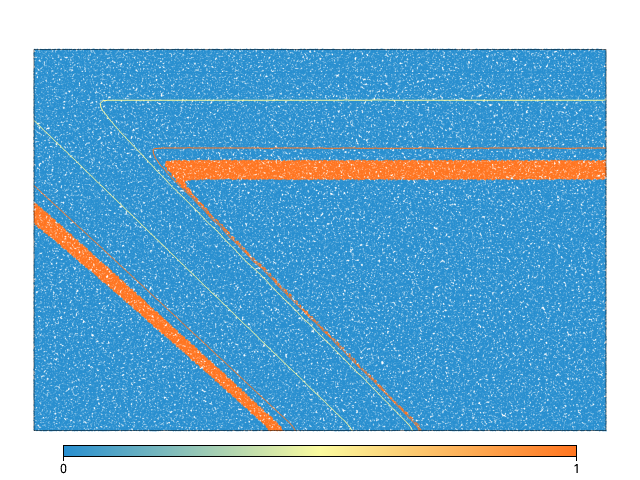

In [92]:
figTemp= glucifer.Figure(quality=3)

figTemp.append( glucifer.objects.Points(swarm, critTempFn , pointSize=2))

figTemp.append( glucifer.objects.Contours( mesh, dimTemp, labelFormat='', unitScaling=1.0, interval=400))

fig.append( glucifer.objects.Contours( mesh, depthFn, labelFormat='', unitScaling=1.0, interval=0.25, colours='black'))


#figTemp.show()
#figTemp.save_database('test.gldb')

%pylab inline
fig, ax = plt.subplots()

ax.plot(temperatureField.evaluate(lWalls)*dp.deltaTemp + dp.surfaceTemp, 
        (1. -mesh.data[lWalls.data][:,1])*sf.lengthScale/1e3, label = 'boussinesq temp')
ax.plot(dimTemp.evaluate(lWalls), 
        (1. - mesh.data[lWalls.data][:,1])*sf.lengthScale/1e3, label = 'adiabatic correction')

ax.set_ylim(400, 0)
ax.legend()


## Get data along fault points

In [144]:
ds = ndp.faultThickness/2.
evalPoints0 = fault.particleCoordinates + fault.director[...]*ds

#Create the temp Swarm
markerEvalFault = uw.swarm.Swarm( mesh=mesh )
catch = markerEvalFault.add_particles_with_coordinates(evalPoints0)



ds = ndp.faultThickness/2.
evalPoints1 = fault.particleCoordinates  - fault.director[...]*ds
#Create the temp Swarm
markerEvalMantle = uw.swarm.Swarm( mesh=mesh )
catch = markerEvalMantle.add_particles_with_coordinates(evalPoints1)

In [145]:
#create velocity magnitude fn
velMagFn = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )

In [146]:
#use a weighted interpolation

ix1, weights1, d1 = nn_evaluation(swarm.particleCoordinates.data, 
                                  markerEvalFault.particleCoordinates.data , n=5, weighted=True)


if len(weights1):
    faultViscData=  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix1], weights=weights1, axis=len((weights1.shape)) - 1)
faultSr2InvData = strainRate_2ndInvariant.evaluate(markerEvalFault)[:,0]
faultVelMag = velMagFn.evaluate(markerEvalFault)[:,0]


#use a weighted interpolation

ix2, weights2, d2 = nn_evaluation(swarm.particleCoordinates.data, 
                                  markerEvalMantle.particleCoordinates.data , n=5, weighted=True)

if len(weights2):
    mantleViscData=  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix2], weights=weights2, axis=len((weights2.shape)) - 1)
mantleSr2InvData = strainRate_2ndInvariant.evaluate(markerEvalMantle)[:,0]
mantleVelMag = velMagFn.evaluate(markerEvalMantle)[:,0]


In [147]:
def save_files():
    
    faultPoints = uw.swarm.SwarmVariable(markerEvalFault, 'double', 2)
    faultVisc = uw.swarm.SwarmVariable(markerEvalFault, 'double', 1)
    faultSr = uw.swarm.SwarmVariable(markerEvalFault, 'double', 1)
    
    faultPoints.data[:] = markerEvalFault.particleCoordinates.data
    faultVisc.data[:,0] = faultViscData
    faultSr.data[:,0] = faultSr2InvData
    #
    

    mantlePoints = uw.swarm.SwarmVariable(markerEvalMantle, 'double', 2)
    mantleVisc = uw.swarm.SwarmVariable(markerEvalMantle, 'double', 1)
    mantleSr = uw.swarm.SwarmVariable(markerEvalMantle, 'double', 1)
    
    mantlePoints.data[:] = markerEvalMantle.particleCoordinates.data
    mantleVisc.data[:,0] = mantleViscData
    mantleSr.data[:,0] = mantleSr2InvData

    
    #Save the files:
    fullpath = os.path.join(outputPath + "files/")
    #fault
    faultPoints.save( fullpath + "faultPoints" + str(step).zfill(5))
    faultVisc.save( fullpath + "faultVisc" + str(step).zfill(5))
    faultSr.save( fullpath + "faultSr" + str(step).zfill(5))
    
    #fault
    mantlePoints.save( fullpath + "mantlePoints" + str(step).zfill(5))
    mantleVisc.save( fullpath + "mantleVisc" + str(step).zfill(5))
    mantleSr.save( fullpath + "mantleSr" + str(step).zfill(5))

In [148]:
save_files()

%pylab inline
fig, ax = plt.subplots()

ax.plot(faultVelMag, 
        (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface'  )
ax.plot(mantleVelMag, 
        (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )


ax.plot()

ax.set_ylim(400, 0)
#ax.set_xlim(0, 50)
ax.legend()


%pylab inline
fig, ax = plt.subplots()

ax.plot((2.*faultViscData*faultSr2InvData)*sf.stress/1e6, 
        (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface', lw=0.5  )
ax.plot((2.*mantleViscData*mantleSr2InvData)*sf.stress/1e6, 
        (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge', lw=0.5  )


ax.plot()

ax.set_ylim(300, 0)
#ax.set_xlim(0, 1000)
ax.legend()
ax.set_xscale('log')

fig, ax = plt.subplots()

ax.plot(temperatureField.evaluate(markerEvalFault)[:,0],
         (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface' )

ax.plot(temperatureField.evaluate(markerEvalMantle)[:,0],
         (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )

ax.plot()

ax.set_ylim(400, 0)
#ax.set_xlim(0, 200)
ax.legend()

fig, ax = plt.subplots()

ax.plot(faultViscData,
         (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface' )

ax.plot(mantleViscData,
         (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )

ax.plot()

ax.set_ylim(400, 0)
#ax.set_xlim(0, 20)
ax.set_xscale('log')
ax.legend()

fig, ax = plt.subplots()

ax.plot(faultSr2InvData,
         (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface' )

ax.plot(mantleSr2InvData,
         (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )

ax.plot()

ax.set_ylim(400, 0)
#ax.set_xlim(0, 200)
ax.set_xscale('log')
ax.legend()